In [62]:
import torch
import numpy as np
import nibabel as ni
import os, shutil
import time
import random
import pandas as pd 

def split_train_test(dir, ratio_test=0.15):
    if not os.path.exists(os.path.join(dir, "train")): os.mkdir(os.path.join(dir, "train"))
    if not os.path.exists(os.path.join(dir, "test")): os.mkdir(os.path.join(dir, "test"))
    
    images_list = [i for i in os.listdir(dir) if i.endswith(".nii")]

    random.shuffle(images_list)
    threshold = int(len(images_list)*ratio_test)
    train_list = images_list[:-threshold]
    test_list = images_list[-threshold:]

    for i in train_list:
        shutil.move(os.path.join(dir, i), os.path.join(dir, "train", i))
    for i in test_list:
        shutil.move(os.path.join(dir, i), os.path.join(dir, "test", i))

def save_data_to_csv(dir, z):
    pd.DataFrame(z).to_csv(dir, header=None, index=False)

def load_mri_images(path, batch_size):
    filenames = [i for i in os.listdir(path) if i.endswith(".nii.gz")] #and i.startswith("norm_023_S_0030")
    random.shuffle(filenames)
    n = 0
    while n < len(filenames):
        batch_image = []
        for i in range(n, n + batch_size):
            if i >= len(filenames):
                ##n = i
                break
            #print(filenames[i])
            image = ni.load(os.path.join(path, filenames[i]))
            # print("Original image shape:", image.shape, "vs (80,96,80)")

            image = np.array(image.dataobj)
            image = np.pad(image, ((1,0), (1,0), (1, 0)), "constant", constant_values=0)
            image = torch.Tensor(image)

            image = torch.reshape(image, (1, 1) + image.shape)  # Keeps original shape if unknown
            # image = torch.reshape(image, (1,1, 80, 96, 80))
            #image = (image - image.min()) / (image.max() - image.min())
            image = image / 255.
            batch_image.append(image)
        n += batch_size
        batch_image = torch.cat(batch_image, axis=0)
        yield batch_image

#################### TEST #################  
path = "C:/Users/kiran/Documents/_UIS/sem6/BACH/Data/_testfew/" 
start = time.time()
loaded = load_mri_images(path, 2)
for i in loaded:
    print(time.time()-start)
    start = time.time()
    print(i.shape)

Original image shape: (208, 240, 256) vs (80,96,80)
Original image shape: (208, 240, 256) vs (80,96,80)
0.4297037124633789
torch.Size([2, 1, 209, 241, 257])


Original image shape: (208, 240, 256) vs (80,96,80)
Converted image shape: (208, 240, 256)
Cropped image shape: (208, 144, 154)


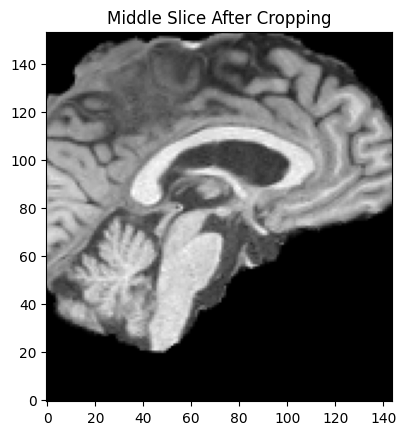

In [63]:
import nibabel as ni
import numpy as np
import matplotlib.pyplot as plt

path = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\_testfew\35_sub-ADNI003S4872_ses-M120_T1w_brain_brain_restore_norm.nii.gz"

# Load MRI image
image = ni.load(path)
print("Original image shape:", image.shape, "vs (80,96,80)")

# Convert to NumPy array
image = np.array(image.get_fdata())  # Use .get_fdata() to retrieve actual image data
print("Converted image shape:", image.shape)  # Should be (208, 240, 256)

# Crop to a region (e.g., center 80x96x80 from 208x240x256)
dx = 0.2
s1 = image.shape[0]
s2 = image.shape[1]
s3 = image.shape[2]
dy = 0.2

image = image[:, 
              round(s2*dx):round(s2*(1-dx)), 
              round(s3*dy):round(s3*(1-dy))]  # Adjust based on observation
print("Cropped image shape:", image.shape)  # Should be (80, 96, 80)

# Display a middle slice from the first axis
plt.imshow(image[image.shape[0] // 2, :, :].T, cmap='gray', origin="lower")
plt.title("Middle Slice After Cropping")
plt.show()


 GPU is activated
Number of MRI images:  44


ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

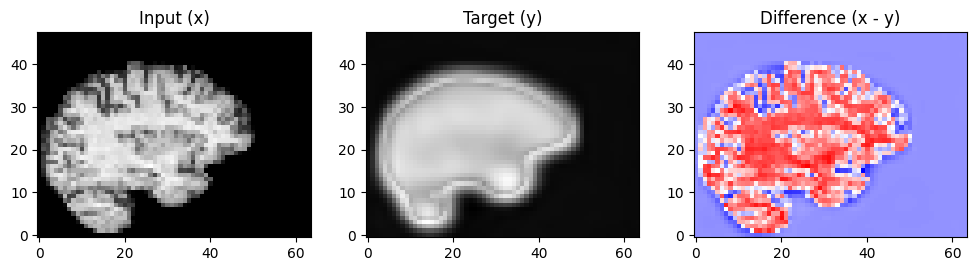

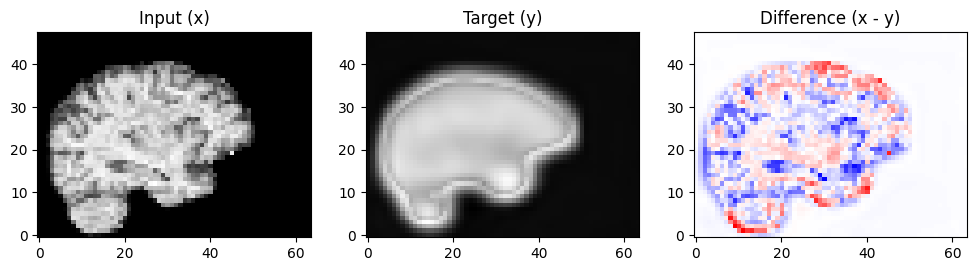

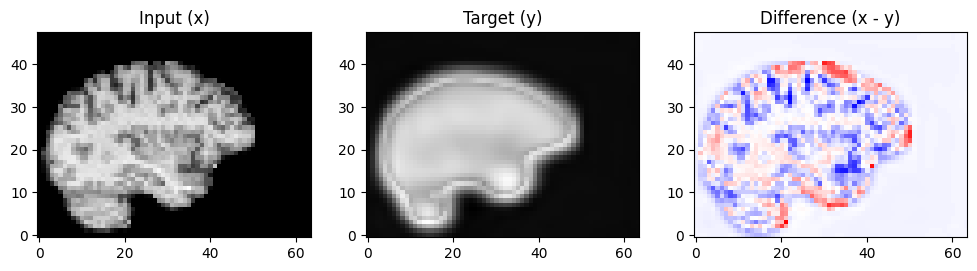

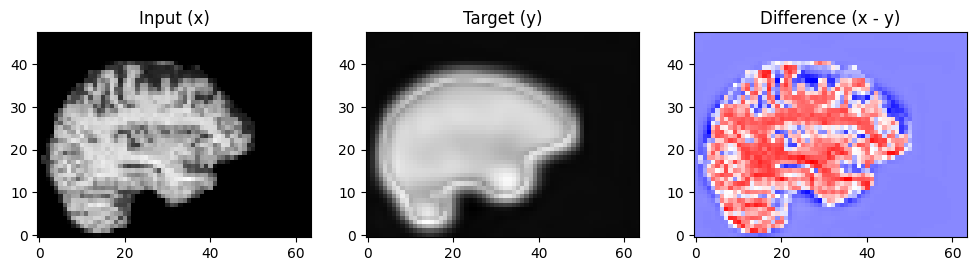

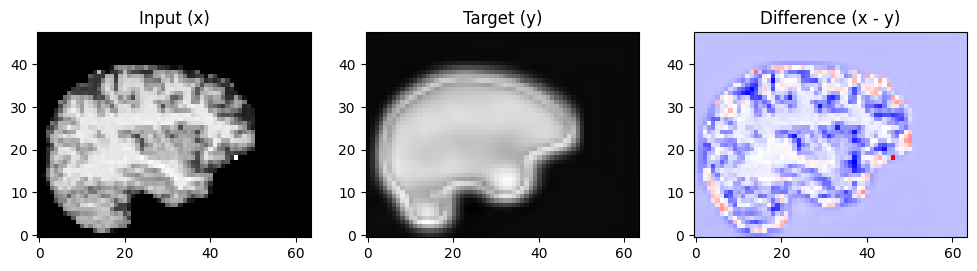

In [ ]:
"""
Author: Duy-Phuong Dao
Email: phuongdd.1997@gmail.com (or duyphuongcri@gmail.com)
"""

import nibabel as ni
import numpy as np
import os, glob
import torch 
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt 

import model
import loss
import dataloader
# import BACH.local.vae_kiran_w6.visualize as visualize
import visualize
from sklearn.decomposition import PCA

##---------Settings--------------------------
batch_size = 1
##############
# path_data = "/home/ubuntu/Desktop/DuyPhuong/VAE/data/test"
# path_model = "./checkpoint/vae_t1/model_vae_epoch_43.pt"
path_data = "C:/Users/kiran/Documents/_UIS/sem6/BACH/Data/_testfew"
path_model = "C:/Users/kiran/Documents/_UIS/sem6/BACH/Data/_test/test200.pt"

####################
verbose = True
log = print if verbose else lambda *x, **i: None
np.random.seed(10)
torch.manual_seed(10)
###################
###################
criterion_rec = loss.L1Loss()
criterion_dis = loss.KLDivergence()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(" GPU is activated" if device else " CPU is activated")
no_images = len(glob.glob(path_data + "/*.nii.gz"))
print("Number of MRI images: ", no_images)
if __name__=="__main__":
    # vae_model = torch.load(path_model)
    vae_model = torch.load(path_model, weights_only=False)

    vae_model.to(device)
    #log(vae_model)
    loss_rec_batch, loss_KL_batch, total_loss_batch = 0, 0, 0
    loss_rec, loss_KL, total_loss = 0, 0, 0
    
    # interfere phrase
    vae_model.eval()
    z = []
    latent_vectors = []
    with torch.no_grad():
        for i, batch_images in enumerate(dataloader.load_mri_images(path_data, batch_size, downscale=3)):
            batch_images = batch_images.to(device)
            y, z_mean, z_log_sigma = vae_model(batch_images)
            z.append((z_mean + z_log_sigma.exp()*vae_model.epsilon).cpu().detach().numpy())

            # Measure loss
            loss_rec_batch = criterion_rec(batch_images, y)
            loss_KL_batch = criterion_dis(z_mean.to(device), z_log_sigma.to(device))
            total_loss_batch = loss_rec_batch + loss_KL_batch

            loss_rec += loss_rec_batch.item() * batch_images.shape[0]
            loss_KL += loss_KL_batch.item() * batch_images.shape[0]
            total_loss += total_loss_batch.item() * batch_images.shape[0]

            # display
            visualize.display_image(batch_images, y)
            
            if i > 3:
                break
                
            latent_vectors.append(z_mean.cpu().numpy())


    print("Reconstruct Loss: {:.4f} | KL Loss: {:.4f}".format(loss_rec/ no_images, loss_KL/ no_images))
    z = np.concatenate(z, axis=0)
    dataloader.save_data_to_csv("./latent_space_z.csv", z)
    print(z.shape)